In [3]:
import kaggle

In [4]:
!kaggle datasets download -d olistbr/brazilian-ecommerce


  0%|          | 0.00/42.7M [00:00<?, ?B/s]
  2%|2         | 1.00M/42.7M [00:00<00:09, 4.83MB/s]
  7%|7         | 3.00M/42.7M [00:00<00:07, 5.78MB/s]
  9%|9         | 4.00M/42.7M [00:00<00:06, 6.63MB/s]
 12%|#1        | 5.00M/42.7M [00:00<00:05, 7.45MB/s]
 16%|#6        | 7.00M/42.7M [00:00<00:04, 8.21MB/s]
 19%|#8        | 8.00M/42.7M [00:00<00:04, 8.76MB/s]
 21%|##1       | 9.00M/42.7M [00:01<00:04, 7.66MB/s]
 23%|##3       | 10.0M/42.7M [00:01<00:04, 7.92MB/s]
 28%|##8       | 12.0M/42.7M [00:01<00:03, 8.45MB/s]
 33%|###2      | 14.0M/42.7M [00:01<00:03, 9.28MB/s]
 37%|###7      | 16.0M/42.7M [00:01<00:02, 9.73MB/s]
 42%|####2     | 18.0M/42.7M [00:01<00:02, 10.3MB/s]
 47%|####6     | 20.0M/42.7M [00:02<00:02, 10.8MB/s]
 51%|#####1    | 22.0M/42.7M [00:02<00:02, 10.7MB/s]
 56%|#####6    | 24.0M/42.7M [00:02<00:01, 10.8MB/s]
 61%|######    | 26.0M/42.7M [00:02<00:01, 10.4MB/s]
 66%|######5   | 28.0M/42.7M [00:02<00:01, 9.87MB/s]
 70%|#######   | 30.0M/42.7M [00:03<00:01, 7.10MB/s]
 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


root_path = '/kaggle/input/brazilian-ecommerce/'
customers_df = pd.read_csv(root_path + 'olist_customers_dataset.csv')
items_df = pd.read_csv(root_path + 'olist_order_items_dataset.csv')
payments_df = pd.read_csv(root_path + 'olist_order_payments_dataset.csv')
orders_df = pd.read_csv(root_path + 'olist_orders_dataset.csv')
products_df = pd.read_csv(root_path + 'olist_products_dataset.csv')
sellers_df = pd.read_csv(root_path + 'olist_sellers_dataset.csv')
categories_df = pd.read_csv(root_path + 'product_category_name_translation.csv')

### Explore the dataset, check number of NAs

In [2]:
datasets = [customers_df, items_df, payments_df, orders_df, products_df, categories_df]
titles = ["customers", "items", "payments", "orders", "products", "categories"]

info_df = pd.DataFrame({},)
info_df['dataset']= titles
info_df['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
info_df['cols_no']= [df.shape[1] for df in datasets]
info_df['null_no']= [df.isnull().sum().sum() for df in datasets]
info_df['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df.style.background_gradient(cmap='coolwarm')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
2,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
3,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
4,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
5,categories,"product_category_name, product_category_name_english",2,0,0,


In [3]:
# Merger dataset together 
# No missing values on the primary key expect product_category_name, we want to get rid of that using inner_join 
df = pd.merge(orders_df,payments_df, on="order_id")
df = df.merge(customers_df, on="customer_id")
df = df.merge(items_df, on="order_id")
df = df.merge(products_df, on="product_id")
df = df.merge(categories_df, on="product_category_name")
df = df.rename(columns = {'product_category_name_english':'cat'})

## Olist customers are not loyal because less than 75% would actually return to make a second purchase 

In [4]:
uniq_cust = orders_df.merge(customers_df, on ='customer_id').groupby('customer_unique_id')['customer_unique_id'].count().sort_values(ascending=False)
uniq_cust

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
                                    ..
a925c3e5df82fdc6082f1383d2834998     1
a92605ec492805540520d3a73aaeeb6e     1
a926aae38267e7f54e67de9b5775d0a5     1
a926cfc9bc7b082335de50450f48eec9     1
0000366f3b9a7992bf8c76cfdf3221e2     1
Name: customer_unique_id, Length: 96096, dtype: int64

In [93]:
uniq_cust.describe()
# only 2997 out of 96096 customers would return 

count    96096.000000
mean         1.034809
std          0.214384
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: customer_unique_id, dtype: float64

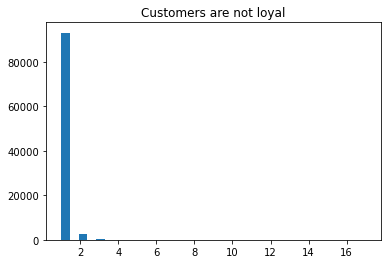

In [108]:
plt.hist(uniq_cust, bins=35)
plt.title('Customers are not loyal')
plt.show()

In [91]:
# Loyalty is roughly the same across different states that have the higest sales
top_states = sales_loc.index.values[:8]
cust_loyal_state = {}
for s in top_states: 
    cust_loyal_state[s]=df[df.customer_state== s].groupby('customer_unique_id')['order_id'].nunique().mean()
cust_loyal_state

{'SP': 1.0343778521448128,
 'RJ': 1.037046204620462,
 'MG': 1.0322141560798548,
 'RS': 1.035009671179884,
 'PR': 1.0326906957250628,
 'BA': 1.0304726368159205,
 'SC': 1.0277617119722382,
 'DF': 1.030511811023622}

In [116]:
# Things that loyal customers would buy 
loyal = uniq_cust[uniq_cust>=2]
df[df['customer_unique_id'].isin(loyal.index)].groupby('cat')['cat'].count().sort_values(ascending=False)

cat
bed_bath_table                           1207
furniture_decor                           867
sports_leisure                            722
health_beauty                             581
computers_accessories                     568
                                         ... 
home_comfort_2                              2
la_cuisine                                  2
small_appliances_home_oven_and_coffee       1
party_supplies                              1
fashion_childrens_clothes                   1
Name: cat, Length: 68, dtype: int64

In [118]:
# Compare to the entire customer base, what would they typically buy
df.groupby('cat')['cat'].count().sort_values(ascending=False)

cat
bed_bath_table               11823
health_beauty                 9972
sports_leisure                8945
furniture_decor               8744
computers_accessories         8082
                             ...  
arts_and_craftmanship           24
la_cuisine                      16
cds_dvds_musicals               14
fashion_childrens_clothes        8
security_and_services            2
Name: cat, Length: 71, dtype: int64

## Overall performance of Olist: sales were booming in 2017, but Olist experienced a slight decline at the end of 2017 but rebounced back in early 2018, then followed by another slight decline in the summer

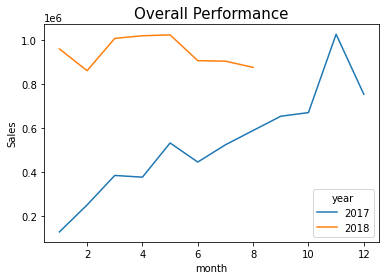

In [96]:
# Overall performance of Olist
df[['order_purchase_timestamp', 'order_delivered_customer_date']]=df[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime)

# Extract "year" from date
df['year'] = df['order_purchase_timestamp'].dt.year
df['month'] = df['order_purchase_timestamp'].dt.month
sales = df[df.order_status != 'canceled'].groupby(['year', 'month'])['price'].sum()
# omit data in year 2016 and in September 2018 because there might be some unknow situations going on (sales are extremely low)
sales = sales.iloc[3:23]
sales.unstack('year').plot()
plt.ylabel('Sales')
plt.title('Overall Performance', size=15)
plt.show()

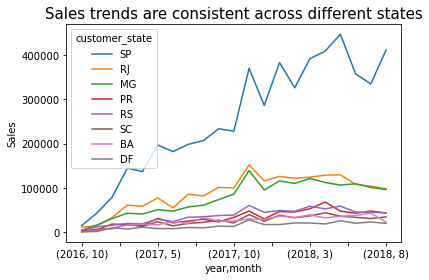

In [95]:
sales_loc_time = df.groupby(['customer_state', 'year', 'month'])['price'].sum().sort_values(ascending=False)
top_states = sales_loc.index.values[:8]
top_states_sales = sales_loc_time[sales_loc_time.index.get_level_values('customer_state').isin(top_states)]
top_states_sales.unstack('customer_state').dropna().plot()
plt.ylabel('Sales')
plt.title('Sales trends are consistent across different states', size=15)
plt.show()

## Two problems Olist are facing: 
#### Customers are not loyal 
#### A slightly downward sales trend in mid 2018

## How to tackle these above issues(retain customers & increase sales): Provide Product Recommendations 

In [178]:
# One possible solutions
# Find product categories that are co-purchased together and display ads on frequently co-purchased categories 
# For example, if customers buy product for Category A tend to buy product from Category B, 
# then Olist can display ads about Category B when customers browse A

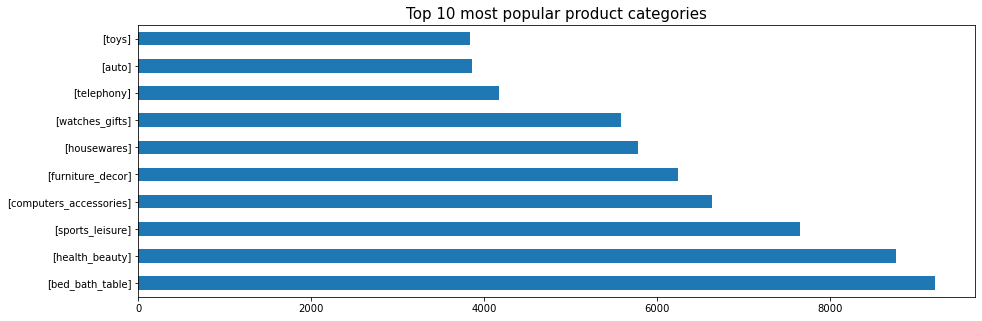

In [6]:
transactions = df.groupby('order_id')['cat'].unique()
transactions.value_counts().sort_values(ascending=False)[:10].plot(kind='barh', figsize=(15,5))
plt.title('Top 10 most popular product categories', size=15)
plt.show()

In [106]:
print("There are a total of %d unique purchases" % orders_df['order_id'].nunique())
print("Out of %d unique transactions, only %d transactions contain products from different categories" %(orders_df['order_id'].nunique(), 
len([i for i in transactions.values if len(i)>1])))
print('Hence, it might be less useful to provide recommendations on a category-wise level')
print('We then focus on providing product-level recommedations, for example, if customers browse on product A, \n we can\
 display ads on certain products based on how frequent they are purchased together')

There are a total of 99441 unique purchases
Out of 99441 unique transactions, only 726 transactions contain products from different categories
Hence, it might be less useful to provide recommendations on a category-wise level
We then focus on providing product-level recommedations, for example, if customers browse on product A, 
 we can display ads on certain products based on how frequent they are purchased together


## What Products to focus on for ads display recommendations 

In [ ]:
# For E-commerce, location is important because people from different states might have different purchasing behaviours
# Hence, I want to focus on states that have the greatest purchasing power and investigate what customers' shopping 
# beharviours look like for those states, specifically I want to narrow down to states "SP", 'RJ' and 'MG' because they 
# contribute the most to Olist's total sales 

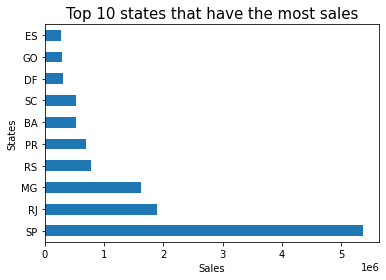

In [93]:
sales_loc = df.groupby('customer_state')['price'].sum().sort_values(ascending = False)
sales_loc.head(10).plot(kind='barh')
plt.xlabel('Sales')
plt.ylabel('States')
plt.title('Top 10 states that have the most sales', size=15)
plt.show()

### Focus on states: SP, RJ and MG

In [113]:
items_df1 = items_df.merge(orders_df, on = 'order_id').merge(
    customers_df[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id')
items_df1 = items_df1[items_df1.customer_state.isin(['SP', 'RJ', 'MG'])]

In [133]:
# We then look at products that are co-purchased together in states SP, RJ and SP
# Since there are 32951 unique products, it might be more helpful to narrow our recommnedations to products that are frequently purchased
prod = items_df1.groupby('product_id').product_id.count()

In [118]:
# On average, products are purchased 3 times, but the dataset is extremely right-skewed 
# and only less than 25% of products got purchased more than 2 times 
prod.describe()

count    25734.000000
mean         2.920533
std          7.907714
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        364.000000
Name: product_id, dtype: float64

In [131]:
# It might not be meaningful to display ads for products that are less commonly purchased
# Hence, I decide to focus on products that are purchased more than 10 times 
pop_prod = prod[prod >= 10]
pop_prod.sort_values(ascending=False).head(10)

product_id
99a4788cb24856965c36a24e339b6058    364
aca2eb7d00ea1a7b8ebd4e68314663af    363
422879e10f46682990de24d770e7f83d    315
389d119b48cf3043d311335e499d9c6b    250
368c6c730842d78016ad823897a372db    236
53759a2ecddad2bb87a079a1f1519f73    236
d1c427060a0f73f6b889a5c7c61f2ac4    233
53b36df67ebb7c41585e8d54d6772e08    224
154e7e31ebfa092203795c972e5804a6    174
2b4609f8948be18874494203496bc318    169
Name: product_id, dtype: int64

In [134]:
# Find orders that contain multiple different products 
ord, freq = np.unique(items_df1.groupby(['order_id', 'product_id'])['order_id'].count().index.get_level_values('order_id').values, return_counts =True)
ord = ord[freq>1]
df1 = items_df1[items_df1.order_id.isin(ord)][['order_id', 'product_id']]
# Find prders that contain different products and at least one of the of products are popular 
pop_ord = df1.order_id[df1.product_id.isin(pop_prod.index.values)]
df1 = df1[df1.order_id.isin(pop_ord)]
df1['qty'] = 1
# Create basket of transactions
basket = df1.groupby(['order_id', 'product_id'])['qty'].count().unstack('product_id').fillna(0)
# Since apriori takes "integer" instead of float 
basket = basket.astype('int32')
basket.head()

product_id,001b72dfd63e9833e8c02742adf472e3,005030ef108f58b46b78116f754d8d38,00ba6d766f0b1d7b78a5ce3e1e033263,0105b5323d24fc655f73052694dbbb3a,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,0152f69b6cf919bcdaf117aa8c43e5a2,017692475c1c954ff597feda05131d73,01cf7c4cffff8db0a1cbe612bd2d50a4,020a80cb704bf65f38761fcedf2af192,...,fe59a1e006df3ac42bf0ceb876d70969,fe6a9515d655fa7936b8a7c841039f34,feb4ade62e32b8d74c6f69f635057964,fec094ad5af771b21cf38c6c9e946f19,fef7934cc233ee5b1dc13094d98a1465,ff285e6c96040323d3763dd184924018,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff9032482857269e8683f0c2f8ba4709,ff95ac47246ef13e48712ea1ff8df0d9
order_id,,,,,,,,,,,,,,,,,,,,,
005d9a5423d47281ac463a968b3936fb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00946f674d880be1f188abc10ad7cf46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01144cadcf64b6427f0a6580a3033220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
012a238ab54294a3b365812ccc82b135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0132451f29a10b66a5cf1bacc85f9afe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# Since an order might contain multiple same products, and we don't care about quantity of purchase at this time
# we will convert everything greater than 1 to 1
qty = basket.max().max()
basket.replace(np.arange(1, qty+1), np.ones(qty).astype('int32'), inplace=True)
(basket>1).sum().sum()

0

In [137]:
# A total of 956 transactions 
basket.head()

product_id,001b72dfd63e9833e8c02742adf472e3,005030ef108f58b46b78116f754d8d38,00ba6d766f0b1d7b78a5ce3e1e033263,0105b5323d24fc655f73052694dbbb3a,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,0152f69b6cf919bcdaf117aa8c43e5a2,017692475c1c954ff597feda05131d73,01cf7c4cffff8db0a1cbe612bd2d50a4,020a80cb704bf65f38761fcedf2af192,...,fe59a1e006df3ac42bf0ceb876d70969,fe6a9515d655fa7936b8a7c841039f34,feb4ade62e32b8d74c6f69f635057964,fec094ad5af771b21cf38c6c9e946f19,fef7934cc233ee5b1dc13094d98a1465,ff285e6c96040323d3763dd184924018,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff9032482857269e8683f0c2f8ba4709,ff95ac47246ef13e48712ea1ff8df0d9
order_id,,,,,,,,,,,,,,,,,,,,,
005d9a5423d47281ac463a968b3936fb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00946f674d880be1f188abc10ad7cf46,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01144cadcf64b6427f0a6580a3033220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
012a238ab54294a3b365812ccc82b135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0132451f29a10b66a5cf1bacc85f9afe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
# Apriori algorithm to find out frequent itemsets 
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(basket, min_support = 0.003, use_colnames = True)
# length: how many different products are there in an order 
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.003138,(005030ef108f58b46b78116f754d8d38),1
1,0.004184,(014a8a503291921f7b004a5215bb3c36),1
2,0.005230,(0152f69b6cf919bcdaf117aa8c43e5a2),1
3,0.005230,(017692475c1c954ff597feda05131d73),1
4,0.003138,(03e931f387c2dd5b006aecdb12515b2e),1
...,...,...,...
185,0.003138,"(b8a0d73b2a06e7910d9864dccdb0cda2, 9bb8ca338e5...",2
186,0.003138,"(9fc98e39f04be8e382d8aa5e259f5489, c403e106353...",2
187,0.003138,"(ad0a798e7941f3a5a2fb8139cb62ad78, b0c89945c03...",2
188,0.005230,"(e6b314a2236c162ede1a879f1075430f, ad4b5def91a...",2


In [124]:
#Create Rules that have confidence greater than 60% 
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.6)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(060cb19345d90064d1015407193c233d),(98d61056e0568ba048e5d78038790e77),0.004184,0.006276,0.004184,1.000000,159.333333,0.004158,inf
1,(98d61056e0568ba048e5d78038790e77),(060cb19345d90064d1015407193c233d),0.006276,0.004184,0.004184,0.666667,159.333333,0.004158,2.987448
2,(0aabfb375647d9738ad0f7b4ea3653b1),(6c3effec7c8ddba466d4f03f982c7aa3),0.008368,0.006276,0.005230,0.625000,99.583333,0.005178,2.649930
3,(6c3effec7c8ddba466d4f03f982c7aa3),(0aabfb375647d9738ad0f7b4ea3653b1),0.006276,0.008368,0.005230,0.833333,99.583333,0.005178,5.949791
4,(0d85c435fd60b277ffb9e9b0f88f927a),(ee57070aa3b24a06fdd0e02efd2d757d),0.005230,0.006276,0.005230,1.000000,159.333333,0.005197,inf
5,(ee57070aa3b24a06fdd0e02efd2d757d),(0d85c435fd60b277ffb9e9b0f88f927a),0.006276,0.005230,0.005230,0.833333,159.333333,0.005197,5.968619
6,(154e7e31ebfa092203795c972e5804a6),(7c1bd920dbdf22470b68bde975dd3ccf),0.005230,0.003138,0.003138,0.600000,191.200000,0.003122,2.492155
7,(7c1bd920dbdf22470b68bde975dd3ccf),(154e7e31ebfa092203795c972e5804a6),0.003138,0.005230,0.003138,1.000000,191.200000,0.003122,inf
8,(dbb67791e405873b259e4656bf971246),(18486698933fbb64af6c0a255f7dd64c),0.005230,0.005230,0.005230,1.000000,191.200000,0.005203,inf
9,(18486698933fbb64af6c0a255f7dd64c),(dbb67791e405873b259e4656bf971246),0.005230,0.005230,0.005230,1.000000,191.200000,0.005203,inf


In [129]:
# For certain products, they have confidence of 1, which means if customers buy Product A, they would for sure buy Product B
# Also, these itemsets have lift ratio far greater than 1, which means they are not purchased together by random chance 
rules[(rules['confidence'] ==1) & (rules['lift']>1)].sort_values(by='support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
22,(5b8a5a9417210b1b84b67b9a7aefb935),(e5ae72c62ebfa708624f5029d609b160),0.006276,0.007322,0.006276,1.0,136.571429,0.006230,inf
4,(0d85c435fd60b277ffb9e9b0f88f927a),(ee57070aa3b24a06fdd0e02efd2d757d),0.005230,0.006276,0.005230,1.0,159.333333,0.005197,inf
8,(dbb67791e405873b259e4656bf971246),(18486698933fbb64af6c0a255f7dd64c),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
9,(18486698933fbb64af6c0a255f7dd64c),(dbb67791e405873b259e4656bf971246),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
23,(5d790355cbeded0cd60e25cbc4c527a2),(5fc3e6a4b52b0c414458104ed4037f1c),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
24,(5fc3e6a4b52b0c414458104ed4037f1c),(5d790355cbeded0cd60e25cbc4c527a2),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
32,(e6b314a2236c162ede1a879f1075430f),(ad4b5def91ac7c575dbdf65b5be311f4),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
33,(ad4b5def91ac7c575dbdf65b5be311f4),(e6b314a2236c162ede1a879f1075430f),0.005230,0.005230,0.005230,1.0,191.200000,0.005203,inf
0,(060cb19345d90064d1015407193c233d),(98d61056e0568ba048e5d78038790e77),0.004184,0.006276,0.004184,1.0,159.333333,0.004158,inf
7,(7c1bd920dbdf22470b68bde975dd3ccf),(154e7e31ebfa092203795c972e5804a6),0.003138,0.005230,0.003138,1.0,191.200000,0.003122,inf
